In [10]:
import datetime
from pathlib import Path
from typing import Dict, List, Union
import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.interpolate import griddata


%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
plt.rcParams.update({'figure.max_open_warning': 0})
PARAMS = {'legend.fontsize': 'xx-large',
          'legend.title_fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(PARAMS)

TIME_FORMAT = '%Y-%m-%d'
INT_TYPE = 'int32'

sns.set_style('whitegrid')
vis_path = 'Visualisation\\smolt_quality_index\\'

In [11]:
def weighted_avg(x, weight, factor):    
    with warnings.catch_warnings():        
        warnings.simplefilter('ignore')        
        tmp = x[[weight, factor]].dropna()        
        weighted_sum = (tmp[weight] * tmp[factor]).sum()        
        count_sum = tmp[weight].sum()        
        return weighted_sum / count_sum

In [12]:
df=pd.read_csv('../data/smolt_quality_index.csv') #,sep=';'
df.columns=pd.Series(df.columns).apply(str.lower)
df['event_date']=pd.to_datetime(df['result_date'])
df['event_year'] = df['event_date'].dt.year

KeyError: 'date'

In [4]:
df.columns

Index(['date', 'locus', 'fish_group', 'stddev', 'p. descamación', 'p. mucus',
       'p. grasa viceral', 'p. peso', 'p. cv', 'smolt_quality_index', 'estado',
       'destination', 'event_date', 'event_year'],
      dtype='object')

In [5]:
dic_locus = pd.read_csv('data\\dic_locus_site_CAM.csv',encoding='windows-1252')
dic_locus = dic_locus[dic_locus.orgunitname=='UPS'] 
# dic_locus
# dic_locus.to_csv('data/dic_locus_site_CAM_UPS.csv',index=False)

In [6]:
# dic_locus[dic_locus.containername=='101M']

In [7]:
df.groupby('estado')['smolt_quality_index'].max()

estado
BUENO        1.020
EXCELENTE    0.500
MALO         2.428
Name: smolt_quality_index, dtype: float64

In [8]:
df=df.merge(dic_locus,left_on=['locus'],right_on=['containername'],how='left')
#drop not needed and NaN columns
df.drop(columns=['fish_group','stddev','estado','destination','site_id','locus_group_id','containername','orgunitname','date'],inplace=True)
# df.drop(columns=['site','etapa_de_muestreo','alteracion_operculo','site_id','locus_group_id','containername','orgunitname','opacidad_corneal','oerculo_corto','inflamados'],inplace=True)
df['p. cv']=df['p. cv'].fillna(0)

In [9]:
df#.columns

,locus,p. descamación,p. mucus,p. grasa viceral,p. peso,p. cv,smolt_quality_index,event_date,event_year,locus_id
0,409,0.0240,0.0080,0.0200,0.0,0.0,0.0520,2023-08-17,2023,3051395
1,406,0.0160,0.0080,0.0000,0.0,0.0,0.0240,2023-08-17,2023,3051487
2,102,0.0200,0.0080,0.0000,0.0,0.0,0.0280,2023-08-17,2023,3049138
3,408M,0.0040,0.0080,0.0000,0.0,0.0,0.0120,2023-08-14,2023,3050037
4,404,0.0040,0.0080,0.0000,0.0,0.0,0.0120,2023-08-14,2023,3050820
...,...,...,...,...,...,...,...,...,...,...
221,101M,0.0023,0.0020,0.0117,0.0,0.0,0.0160,2021-02-01,2021,3046035
222,409H,0.0027,0.0080,0.0233,0.0,0.0,0.0340,2021-01-29,2021,3048380
223,403H,0.0180,0.0053,0.0267,0.0,0.0,0.0500,2021-01-29,2021,3050085
224,208M,0.0047,0.0067,0.0200,0.0,0.0,0.0314,2021-01-29,2021,3046379


In [10]:
print(len(df))
df=df[df['p. grasa viceral']<df['p. grasa viceral'].quantile(.99)]
print(len(df))

226
223


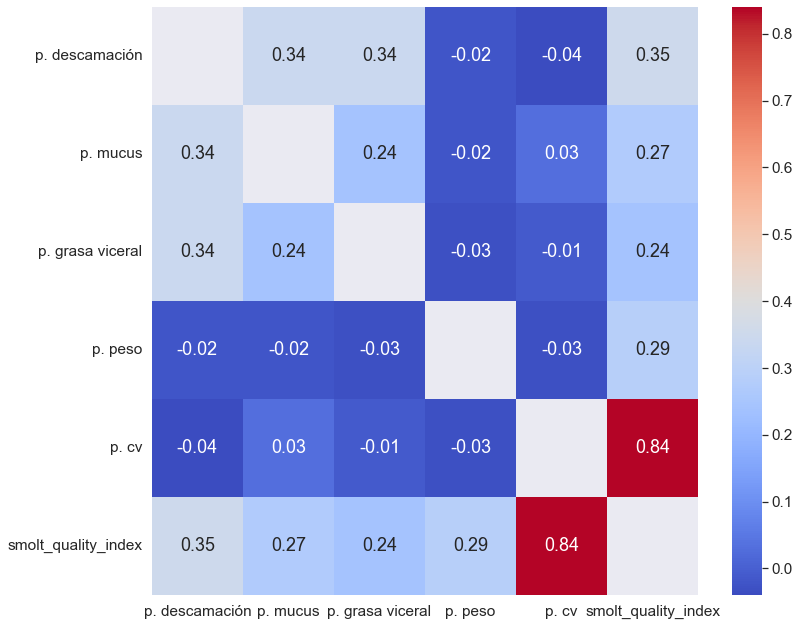

In [11]:
corr = df.iloc[:,:-2].corr().round(2)
np.fill_diagonal(corr.values, np.nan)

sns.set(font_scale=1.4)
fig = plt.figure(figsize=(12, 9))
ax = plt.subplot(1, 1, 1)
sns.heatmap(corr, ax=ax, cmap='coolwarm', annot=True, annot_kws={"size": 18})
plt.tight_layout()
# plt.savefig(vis_path+'sqi_corr_heatmap.png',dpi=300)

In [12]:
df.shape

(223, 10)

In [13]:
factors =  ['p. descamación', 'p. mucus',
       'p. grasa viceral', 'p. cv', 'smolt_quality_index']

In [14]:
# df['destino'].value_counts()

In [15]:
dftar=pd.read_csv('data\\new\\targets.csv')

swfw=pd.read_csv('data/new/sw_locus_fw_locus_population_with_counts.csv')
swfw['transfer_date'] = pd.to_datetime(swfw['transfer_date'])
swfw['transfer_year']= swfw.transfer_date.dt.year

swfw=swfw.merge(dftar,left_on=['to_locus_id','to_fish_group_id','transfer_year'],
           right_on=['locus_id','fish_group_id','transfer_year'],how='left')

In [16]:
# swfw[swfw.from_locus_id==3046029    ]

In [17]:
tmpdf1=pd.DataFrame(swfw[['from_locus_id','transfer_year','total_mortality_perc_90','nSFR','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'total_mortality_perc_90'))
tmpdf1.columns=['mortality']
tmpdf2=pd.DataFrame(swfw[['from_locus_id','transfer_year','total_mortality_perc_90','nSFR','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'nSFR'))
tmpdf2.columns=['nsfr']
tmpdf3=pd.DataFrame(swfw[['from_locus_id','transfer_year','from_avg_weight','from_count_stocking']].groupby(['from_locus_id','transfer_year']).apply(weighted_avg, 'from_count_stocking', 'from_avg_weight'))
tmpdf3.columns=['stocking_weight']

fw_performance=tmpdf1.merge(tmpdf2,left_index=True,right_index=True).dropna()
fw_performance=fw_performance.merge(tmpdf3,left_index=True,right_index=True)
# fw_performance.to_csv('data/fw_performance.csv')

fw_performance_=fw_performance.reset_index()
df_=df.merge(fw_performance_,left_on=['locus_id','event_year'],right_on=['from_locus_id','transfer_year'],how='left')

In [18]:
# fw_performance.hist()

In [19]:
df__=df_[~df_.mortality.isna()]
# for c in ['grado_3','inflamados','opacidad_corneal','oerculo_corto','cataratas']:
# for c in ['grado_3','cataratas']:
#     df__[c] = df__[c].fillna(0)
df_2022=df__.copy()
df_2022['mortality']=df_2022['mortality']*100
df_2022=df_2022[df_2022.mortality<15]

In [20]:
# #filter 3 records from 2021
# print(len(df__))
# df_2022=df__[df__.event_year==2022]
# print(len(df_2022))
# #remove 5 records with wrong labeling
# df_2022=df_2022[(df_2022['normal']+df_2022['grado_1']+df_2022['grado_2']+df_2022['grado_3'])>=0.98]
# print(len(df_2022))
# df_2022['mortality']=df_2022['mortality']*100

In [21]:
# df_2022#.density.describe()

In [22]:
df_2022.groupby(['event_date','locus']).count().max()

p. descamación         1
p. mucus               1
p. grasa viceral       1
p. peso                1
p. cv                  1
smolt_quality_index    1
event_year             1
locus_id               1
from_locus_id          1
transfer_year          1
mortality              1
nsfr                   1
stocking_weight        1
dtype: int64

In [23]:
# #grouping
# df_2022_=pd.DataFrame()
# for factor in factors+['mortality','nsfr','stocking_weight']:
#     tmpdf = pd.DataFrame(df_2022.groupby(['event_date','locus']).apply(weighted_avg, 'cantidad_muestreada', factor))
#     tmpdf.columns = [factor]
#     df_2022_=pd.concat([df_2022_,tmpdf],1)

In [24]:
df_2022_=df_2022.set_index(['event_date','locus'])[factors+['mortality','nsfr','stocking_weight']]

In [25]:
df_2022_

p. descamación  p. mucus  p. grasa viceral  p. cv  \
event_date locus                                                      
2023-08-17 102            0.0200    0.0080            0.0000    0.0   
2023-08-14 404            0.0040    0.0080            0.0000    0.0   
           202            0.0200    0.0000            0.0000    0.0   
2023-07-06 310            0.0400    0.0240            0.0000    0.5   
2023-05-23 508            0.0160    0.0000            0.0000    0.0   
...                          ...       ...               ...    ...   
2021-02-24 503H           0.0007    0.0000            0.0000    0.0   
           404H           0.0027    0.0027            0.0033    0.0   
           203H           0.0040    0.0040            0.0100    0.5   
2021-02-23 304H           0.0040    0.0027            0.0000    0.0   
           102H           0.0053    0.0053            0.0000    0.0   

                  smolt_quality_index  mortality      nsfr  stocking_weight  
event_date locus                                                             
2023-08-17 102                 0.0280   0.698423  0.832373       150.216072  
2023-08-14 404                 0.0120   0.665985  0.943874       153.598138  
           202                 0.0200   0.515550  0.925123       216.215344  
2023-07-06 310                 0.5640   6.499912  0.985779       153.509219  
2023-05-23 508                 0.0160   0.585924  0.869693       205.834377  
...                               ...        ...       ...              ...  
2021-02-24 503H                0.0007   1.250676  0.844805       144.000000  
           404H                0.0087   0.764156  0.808537       183.581463  
           203H                0.5180   0.806403  0.838963       158.000000  
2021-02-23 304H                0.0067   1.004695  0.902780       134.638575  
           102H                0.0106   0.914958  0.887162       178.677998  

[193 rows x 8 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


event_date


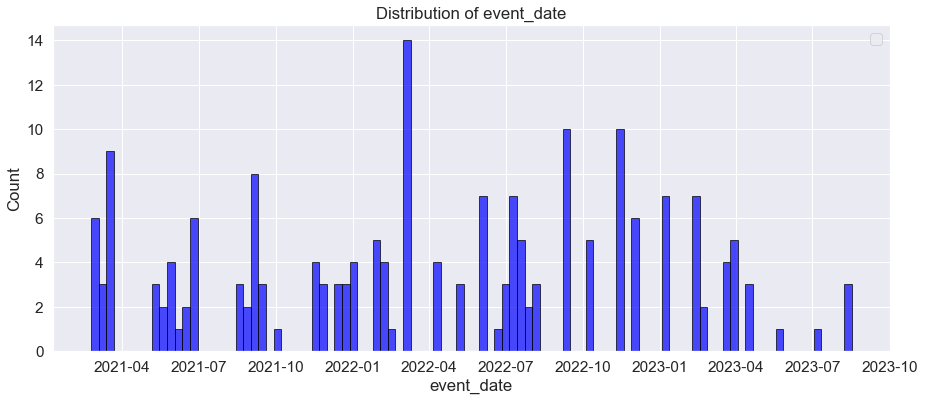

In [38]:
arr_for_chart = df_2022.copy()
#plot histograms
for factor in ['event_date']:
    print(factor)
    plt.figure(figsize=(15, 6))
    plt.hist(arr_for_chart[factor], bins=100, alpha=0.7, color='blue', edgecolor='black')

    # Add a vertical line for the mean value
    mean_value = np.mean(arr_for_chart[factor])
#     if factor =='event_date':
#         plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value.date()}')
#     else:
#         plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.3f}')

    # Add labels and title
    plt.xlabel(factor)
    plt.ylabel('Count')
    plt.title(f'Distribution of {factor}')
    plt.legend()

    # Save the plot
    plt.savefig(vis_path + f'{factor}_histogram.jpg')

    # Show the plot
    plt.show()

p. descamación


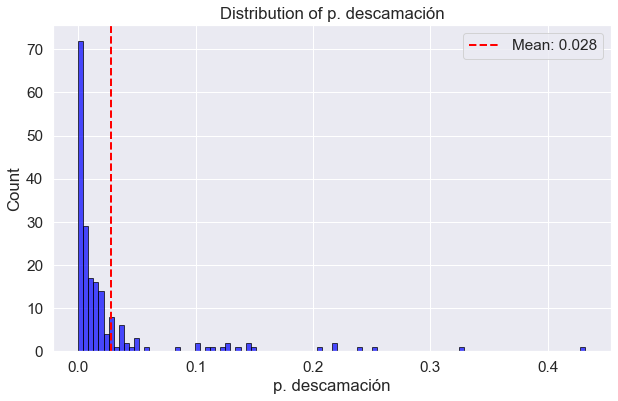

p. mucus


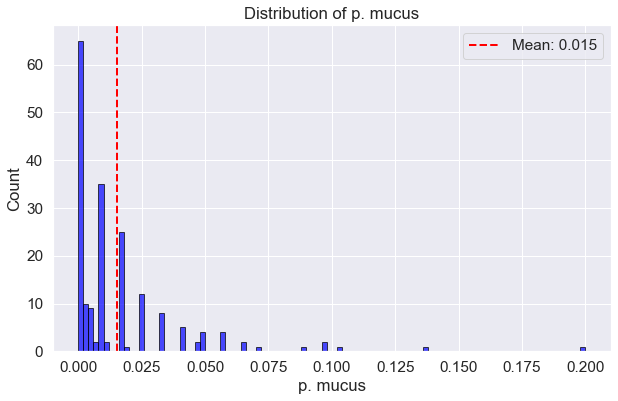

p. grasa viceral


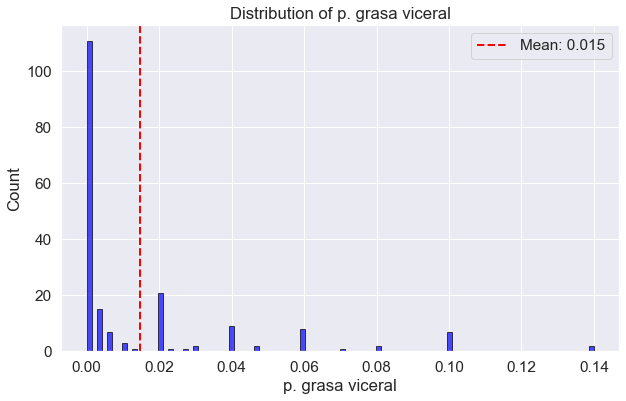

p. cv


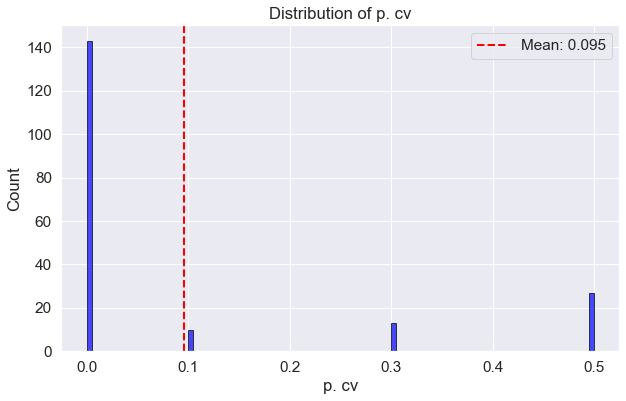

smolt_quality_index


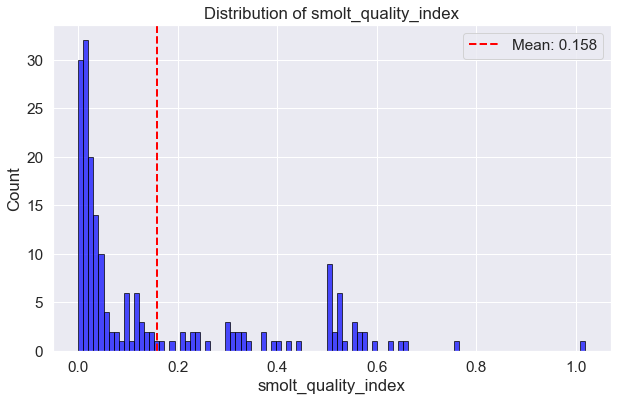

In [39]:
arr_for_chart = df_2022_.copy()
#plot histograms
for factor in factors:
    print(factor)
    plt.figure(figsize=(10, 6))
    plt.hist(arr_for_chart[factor], bins=100, alpha=0.7, color='blue', edgecolor='black')

    # Add a vertical line for the mean value
    mean_value = np.mean(arr_for_chart[factor])
    if factor =='event_date':
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value.date()}')
    else:
        plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_value:.3f}')

    # Add labels and title
    plt.xlabel(factor)
    plt.ylabel('Count')
    plt.title(f'Distribution of {factor}')
    plt.legend()

    # Save the plot
    plt.savefig(vis_path + f'{factor}_histogram.jpg')

    # Show the plot
    plt.show()

In [26]:
df_2022_.reset_index()

,event_date,locus,p. descamación,p. mucus,p. grasa viceral,p. cv,smolt_quality_index,mortality,nsfr,stocking_weight
0,2023-08-17,102,0.0200,0.0080,0.0000,0.0,0.0280,0.698423,0.832373,150.216072
1,2023-08-14,404,0.0040,0.0080,0.0000,0.0,0.0120,0.665985,0.943874,153.598138
2,2023-08-14,202,0.0200,0.0000,0.0000,0.0,0.0200,0.515550,0.925123,216.215344
3,2023-07-06,310,0.0400,0.0240,0.0000,0.5,0.5640,6.499912,0.985779,153.509219
4,2023-05-23,508,0.0160,0.0000,0.0000,0.0,0.0160,0.585924,0.869693,205.834377
...,...,...,...,...,...,...,...,...,...,...
188,2021-02-24,503H,0.0007,0.0000,0.0000,0.0,0.0007,1.250676,0.844805,144.000000
189,2021-02-24,404H,0.0027,0.0027,0.0033,0.0,0.0087,0.764156,0.808537,183.581463
190,2021-02-24,203H,0.0040,0.0040,0.0100,0.5,0.5180,0.806403,0.838963,158.000000
191,2021-02-23,304H,0.0040,0.0027,0.0000,0.0,0.0067,1.004695,0.902780,134.638575


In [41]:
df_2022_

p. descamación  p. mucus  p. grasa viceral  p. cv  \
event_date locus                                                      
2023-08-17 102            0.0200    0.0080            0.0000    0.0   
2023-08-14 404            0.0040    0.0080            0.0000    0.0   
           202            0.0200    0.0000            0.0000    0.0   
2023-07-06 310            0.0400    0.0240            0.0000    0.5   
2023-05-23 508            0.0160    0.0000            0.0000    0.0   
...                          ...       ...               ...    ...   
2021-02-24 503H           0.0007    0.0000            0.0000    0.0   
           404H           0.0027    0.0027            0.0033    0.0   
           203H           0.0040    0.0040            0.0100    0.5   
2021-02-23 304H           0.0040    0.0027            0.0000    0.0   
           102H           0.0053    0.0053            0.0000    0.0   

                  smolt_quality_index  mortality      nsfr  stocking_weight  
event_date locus                                                             
2023-08-17 102                 0.0280   0.698423  0.832373       150.216072  
2023-08-14 404                 0.0120   0.665985  0.943874       153.598138  
           202                 0.0200   0.515550  0.925123       216.215344  
2023-07-06 310                 0.5640   6.499912  0.985779       153.509219  
2023-05-23 508                 0.0160   0.585924  0.869693       205.834377  
...                               ...        ...       ...              ...  
2021-02-24 503H                0.0007   1.250676  0.844805       144.000000  
           404H                0.0087   0.764156  0.808537       183.581463  
           203H                0.5180   0.806403  0.838963       158.000000  
2021-02-23 304H                0.0067   1.004695  0.902780       134.638575  
           102H                0.0106   0.914958  0.887162       178.677998  

[193 rows x 8 columns]

In [42]:
# arr_for_chart = df_2022_.copy()

# # Plot the histogram
# plt.figure(figsize=(15, 6))

# bins_number = 10

# plt.hist(arr_for_chart['p. descamación'], bins=bins_number, alpha=0.5, color='blue', edgecolor='black', label='Normal')
# plt.hist(arr_for_chart['p. mucus'], bins=bins_number, alpha=0.5, color='green', edgecolor='black', label='Grado 1')
# plt.hist(arr_for_chart['p. grasa viceral'], bins=bins_number, alpha=0.5, color='orange', edgecolor='black', label='Grado 2')
# plt.hist(arr_for_chart['p. peso'], bins=bins_number, alpha=0.5, color='red', edgecolor='black', label='Grado 3')
# plt.hist(arr_for_chart['p. cv'], bins=bins_number, alpha=0.5, color='red', edgecolor='black', label='Grado 3')

# # Add labels and title
# plt.xlabel('Factor Values')
# plt.ylabel('Count')
# # plt.title('Distribution of Different Factors')
# plt.legend()

# # plt.savefig(vis_path + f'joint_sqi_histogram.png',dpi=300)

In [43]:
# fw_performance_[fw_performance_.from_locus_id==3047489]

In [44]:
# swfw[(swfw.from_locus_id==3047489)&(swfw.transfer_year==2022)]

In [45]:
# dfmvmt = pd.read_csv('data/evt_movement_ratio_with_dates.csv')
# dfmvmt['starttime'] = pd.to_datetime(dfmvmt['starttime'])
# dfmvmt[(dfmvmt.historic_locus_id==3047489)&(dfmvmt.starttime.dt.year==2022)].tail(20)

In [46]:
#for 26 rows target values are not defined
# df_[df_.mortality.isna()]

In [38]:
df_2022_[factors+['stocking_weight','mortality']].corr()['smolt_quality_index'].sort_values()

stocking_weight       -0.106898
mortality              0.018965
p. grasa viceral       0.251304
p. mucus               0.268858
p. descamación         0.340139
p. cv                  0.844965
smolt_quality_index    1.000000
Name: smolt_quality_index, dtype: float64

In [47]:
df_2022_[factors+['stocking_weight','mortality']].corr()['mortality'].sort_values()

stocking_weight       -0.185788
p. grasa viceral      -0.116056
p. mucus              -0.020261
smolt_quality_index    0.018965
p. descamación         0.027522
p. cv                  0.042288
mortality              1.000000
Name: mortality, dtype: float64

In [48]:
df_2022_[factors+['stocking_weight','mortality','nsfr']].corr()['nsfr'].sort_values()

stocking_weight       -0.203423
p. descamación        -0.085317
p. mucus              -0.083735
p. grasa viceral      -0.080534
mortality             -0.041358
smolt_quality_index    0.063050
p. cv                  0.119339
nsfr                   1.000000
Name: nsfr, dtype: float64

In [49]:
# df_2022_[factors+['stocking_weight','mortality']].corr()['mortality'].sort_values()

In [50]:
# df_2022_[factors+['stocking_weight','nsfr']].corr()['nsfr'].sort_values()

In [51]:
# (df__['normal']+df__['grado_1']+df__['grado_2']+df__['grado_3']).hist(bins=100)

In [52]:
factors

['p. descamación',
 'p. mucus',
 'p. grasa viceral',
 'p. cv',
 'smolt_quality_index']

In [35]:
[f for f in factors if f!='smolt_quality_index']

['p. descamación', 'p. mucus', 'p. grasa viceral', 'p. cv']

p. descamación smolt_quality_index
p. mucus smolt_quality_index
p. grasa viceral smolt_quality_index
p. cv smolt_quality_index


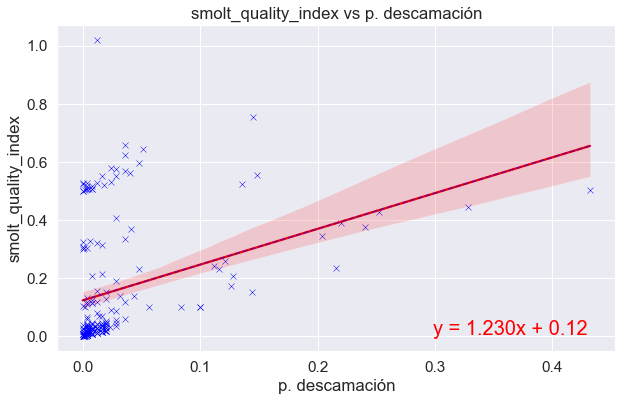

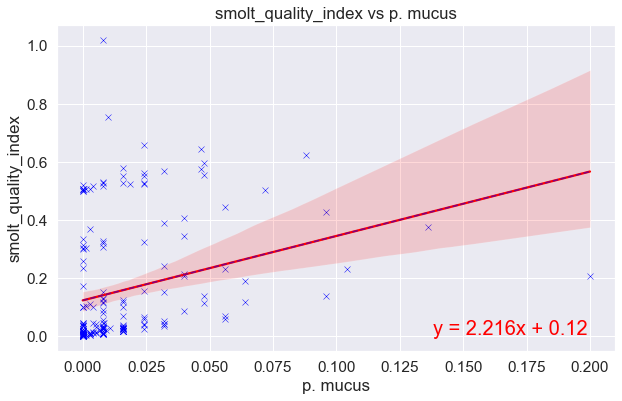

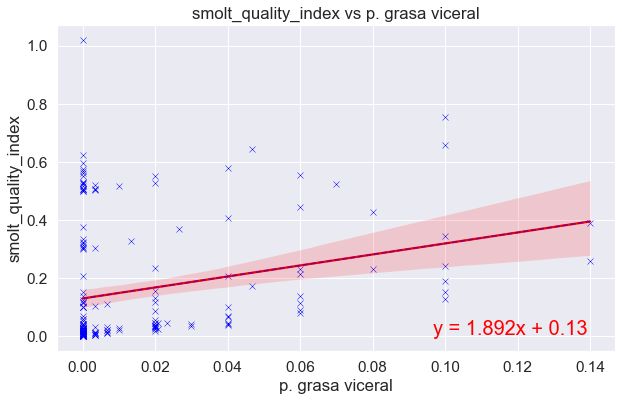

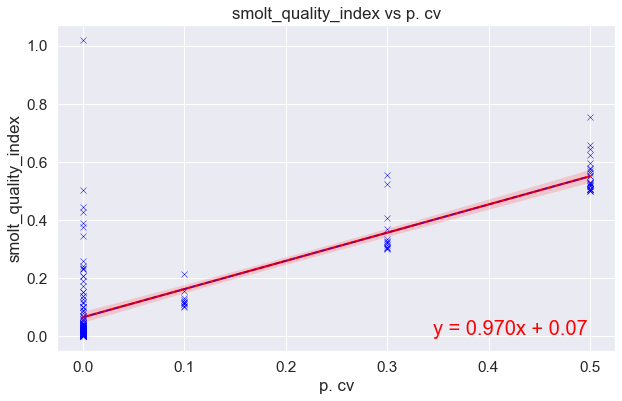

In [37]:
# Format y-axis as a percentage
def percent_formatter(x, pos):
    return f'{x:.1f}%'
# target = 'mortality'
for factor in [f for f in factors if f!='smolt_quality_index']:
#     for target in ['mortality','nsfr']:
    for target in ['smolt_quality_index']:
        print(factor,target)
        arr_for_chart = df_2022_[[factor,target]].dropna()#[df__.grado_1>df__.grado_1.quantile(.05)]
        # arr_for_chart = df__[df__.stocking_weight.between(140,180)]
        # Create the scatter plot with crosses as markers
        plt.figure(figsize=(10, 6))
        scatter_plot = sns.scatterplot(data=arr_for_chart, x=factor, y=target, marker='x', color='blue')

        # Add a trendline with equation
        sns.regplot(data=arr_for_chart, x=factor, y=target, scatter=False, ax=scatter_plot, color='red', label='Trendline')

        # Get the slope and intercept for the trendline
        slope, intercept = np.polyfit(arr_for_chart[factor], arr_for_chart[target], 1)

        # Add the equation to the plot
        equation = f'y = {slope:.3f}x + {intercept:.2f}'
        plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')


        if target=='mortality':
            plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

        # Set x-axis limits and ticks
        # plt.xlim(0, 0.6)
        # plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

        # Extrapolate trendline beyond the range
        extrapolated_x = np.array([0, arr_for_chart[factor].max()])  # Your desired extrapolation range
        extrapolated_y = extrapolated_x * slope + intercept
        plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


        plt.xlabel(factor)
        plt.ylabel(target)
        title = f'{target} vs {factor}'
        plt.title(title)
        # plt.legend()

        plt.savefig(vis_path + title+ f'.png',dpi=300)

p. descamación mortality
p. descamación nsfr
p. mucus mortality
p. mucus nsfr
p. grasa viceral mortality
p. grasa viceral nsfr
p. cv mortality
p. cv nsfr
smolt_quality_index mortality
smolt_quality_index nsfr
stocking_weight mortality
stocking_weight nsfr


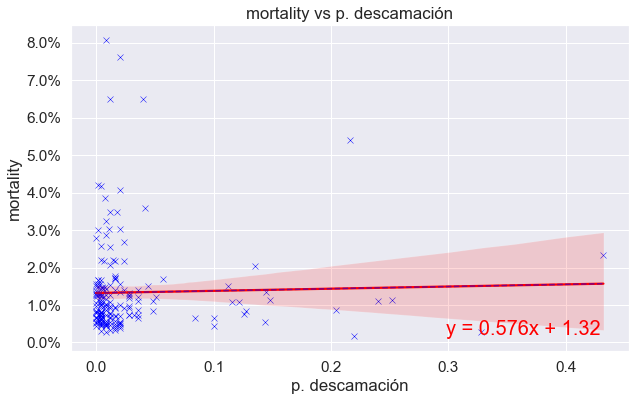

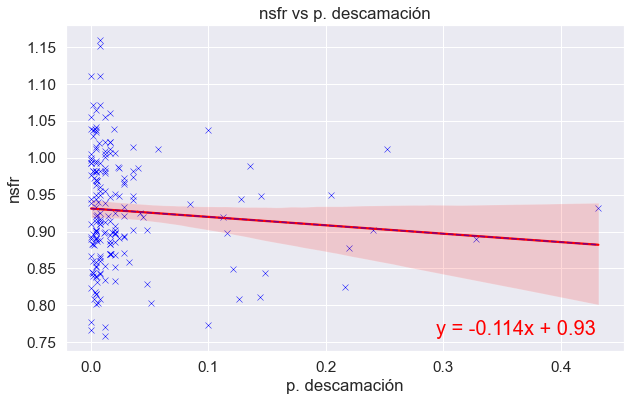

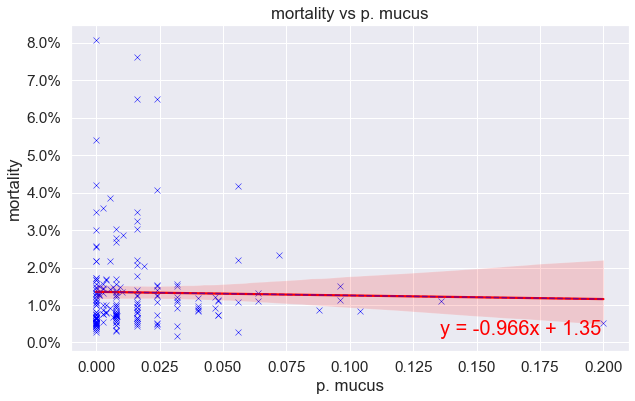

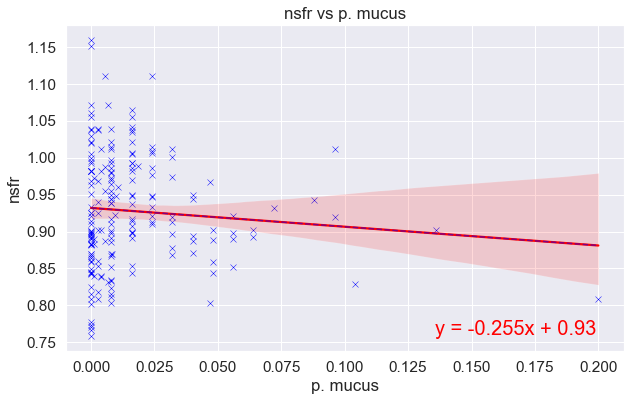

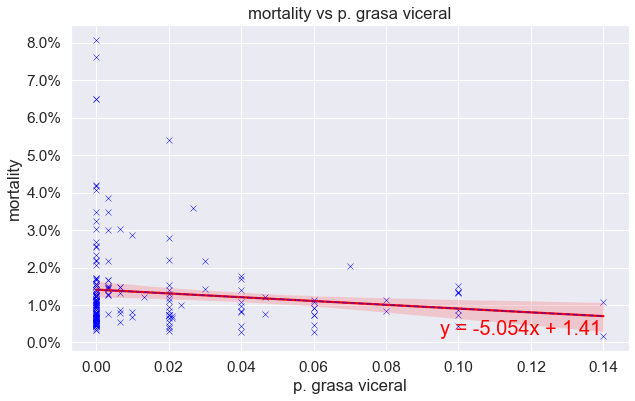

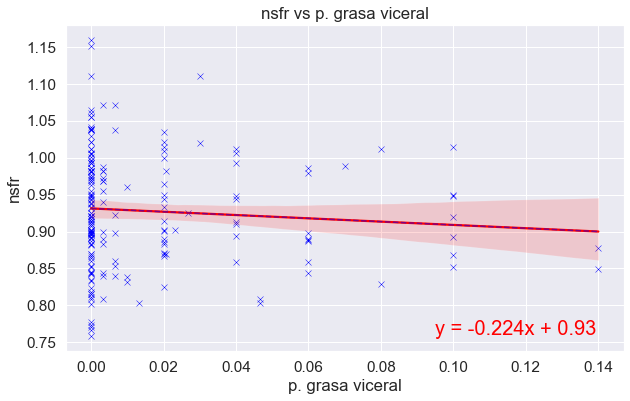

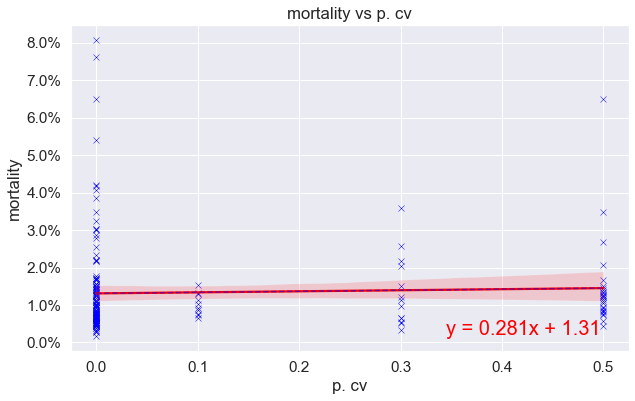

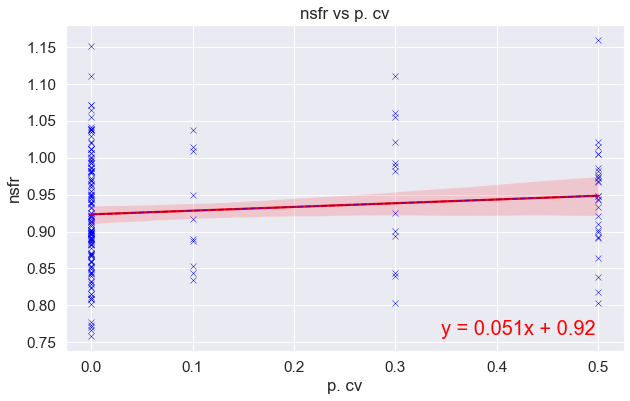

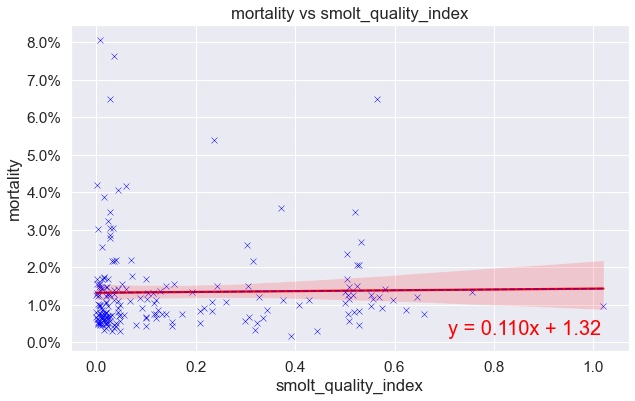

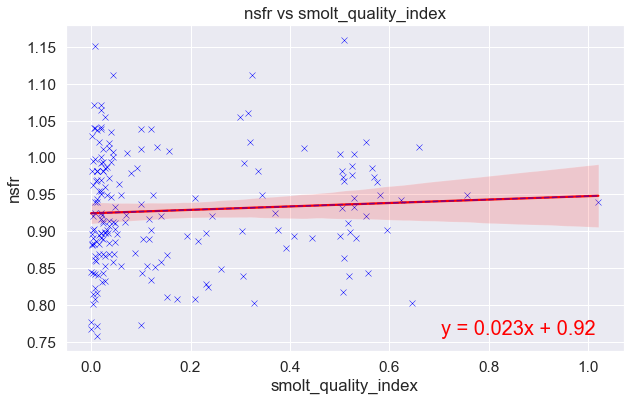

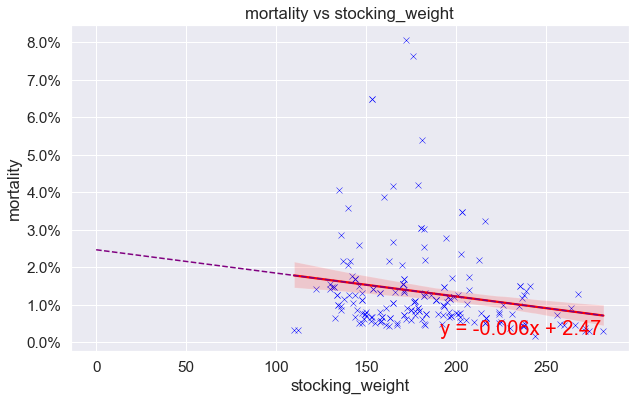

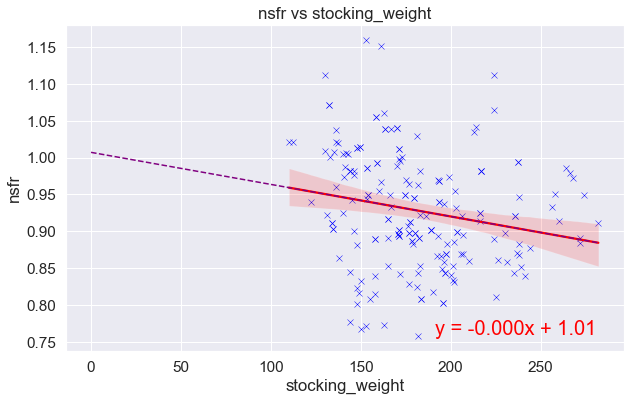

In [40]:
# Format y-axis as a percentage
def percent_formatter(x, pos):
    return f'{x:.1f}%'
# target = 'mortality'
for factor in factors+['stocking_weight']:
    for target in ['mortality','nsfr']:
#     for target in ['mortality']:
        print(factor,target)
        arr_for_chart = df_2022_[[factor,target]].dropna()#[df__.grado_1>df__.grado_1.quantile(.05)]
        # arr_for_chart = df__[df__.stocking_weight.between(140,180)]
        # Create the scatter plot with crosses as markers
        plt.figure(figsize=(10, 6))
        scatter_plot = sns.scatterplot(data=arr_for_chart, x=factor, y=target, marker='x', color='blue')

        # Add a trendline with equation
        sns.regplot(data=arr_for_chart, x=factor, y=target, scatter=False, ax=scatter_plot, color='red', label='Trendline')

        # Get the slope and intercept for the trendline
        slope, intercept = np.polyfit(arr_for_chart[factor], arr_for_chart[target], 1)

        # Add the equation to the plot
        equation = f'y = {slope:.3f}x + {intercept:.2f}'
        plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')


        if target=='mortality':
            plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

        # Set x-axis limits and ticks
        # plt.xlim(0, 0.6)
        # plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

        # Extrapolate trendline beyond the range
        extrapolated_x = np.array([0, arr_for_chart[factor].max()])  # Your desired extrapolation range
        extrapolated_y = extrapolated_x * slope + intercept
        plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


        plt.xlabel(factor)
        plt.ylabel(target)
        title = f'{target} vs {factor}'
        plt.title(title)
        # plt.legend()

        plt.savefig(vis_path + title+ f'.png',dpi=300)

In [55]:
df_2022_[factors+['mortality','nsfr','stocking_weight']].describe()

,p. descamación,p. mucus,p. grasa viceral,p. cv,smolt_quality_index,mortality,nsfr,stocking_weight
count,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000
mean,0.027832,0.015447,0.014584,0.095337,0.158381,1.336097,0.928080,181.514022
std,0.057360,0.025170,0.027565,0.180650,0.207477,1.200319,0.076536,35.809926
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.160117,0.757747,110.000000
25%,0.004000,0.000000,0.000000,0.000000,0.016000,0.665315,0.877937,153.598138
50%,0.008000,0.008000,0.000000,0.000000,0.043300,1.004695,0.920041,177.000000
75%,0.020000,0.016000,0.020000,0.100000,0.244000,1.473251,0.982319,201.000000
max,0.432000,0.200000,0.140000,0.500000,1.020000,8.071264,1.159756,282.000000


In [56]:
df_2022_[factors+['mortality','nsfr','stocking_weight']].corr()

,p. descamación,p. mucus,p. grasa viceral,p. cv,smolt_quality_index,mortality,nsfr,stocking_weight
p. descamación,1.000000,0.406041,0.433869,-0.041689,0.340139,0.027522,-0.085317,0.159280
p. mucus,0.406041,1.000000,0.235246,0.013164,0.268858,-0.020261,-0.083735,0.029932
p. grasa viceral,0.433869,0.235246,1.000000,-0.019250,0.251304,-0.116056,-0.080534,0.227678
p. cv,-0.041689,0.013164,-0.019250,1.000000,0.844965,0.042288,0.119339,-0.221867
smolt_quality_index,0.340139,0.268858,0.251304,0.844965,1.000000,0.018965,0.063050,-0.106898
mortality,0.027522,-0.020261,-0.116056,0.042288,0.018965,1.000000,-0.041358,-0.185788
nsfr,-0.085317,-0.083735,-0.080534,0.119339,0.063050,-0.041358,1.000000,-0.203423
stocking_weight,0.159280,0.029932,0.227678,-0.221867,-0.106898,-0.185788,-0.203423,1.000000


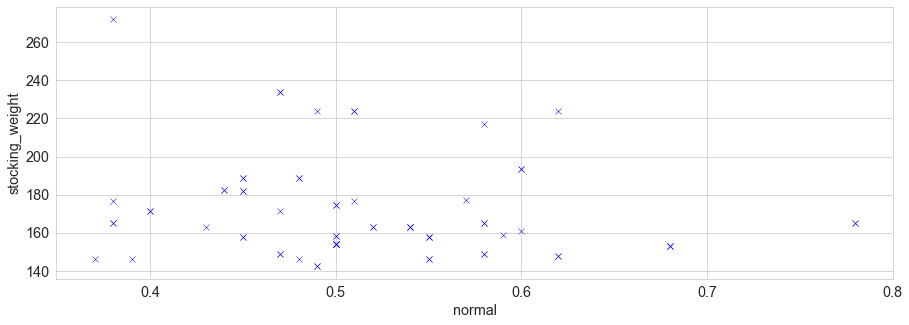

In [176]:
# scatter_plot = sns.scatterplot(data=df_2022, x='normal', y='stocking_weight', marker='x', color='blue')

In [57]:
factors

['p. descamación',
 'p. mucus',
 'p. grasa viceral',
 'p. cv',
 'smolt_quality_index']

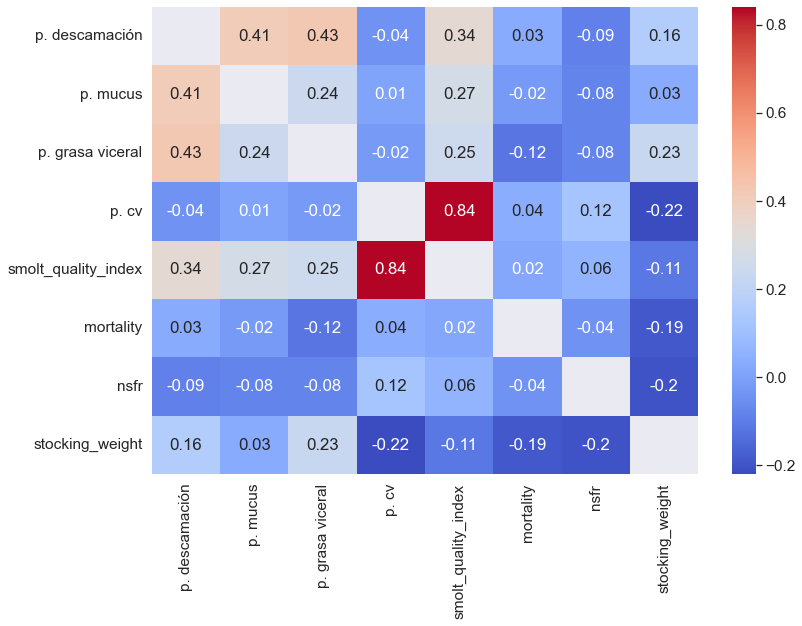

In [59]:
corr = df_2022_.corr().round(2)
np.fill_diagonal(corr.values, np.nan)

# Create a heatmap without diagonal correlations
fig = plt.figure(figsize=(12, 9))
ax = plt.subplot(1, 1, 1)
sns.heatmap(corr, ax=ax, cmap='coolwarm', annot=True)
plt.tight_layout()
plt.savefig(vis_path+'sqi_corr_heatmap_with_targets.png',dpi=300)

p. cv smolt_quality_index


Text(0.5, 1.0, 'smolt_quality_index vs p. cv')

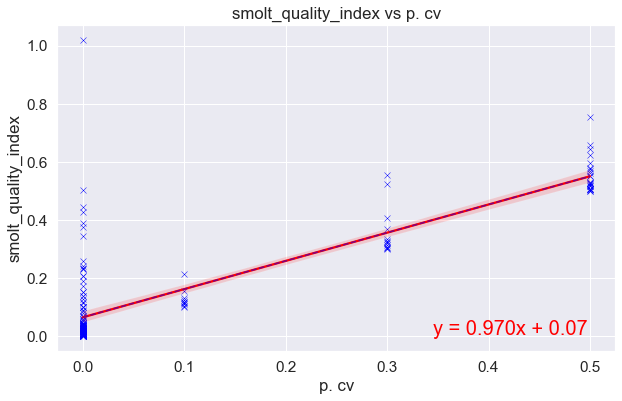

In [60]:
# Format y-axis as a percentage
def percent_formatter(x, pos):
    return f'{x:.1f}%'
factor = 'p. cv'
target = 'smolt_quality_index'
print(factor,target)
arr_for_chart = df_2022_[[factor,target]].dropna()#[df__.grado_1>df__.grado_1.quantile(.05)]
# arr_for_chart = df__[df__.stocking_weight.between(140,180)]
# Create the scatter plot with crosses as markers
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=arr_for_chart, x=factor, y=target, marker='x', color='blue')

# Add a trendline with equation
sns.regplot(data=arr_for_chart, x=factor, y=target, scatter=False, ax=scatter_plot, color='red', label='Trendline')

# Get the slope and intercept for the trendline
slope, intercept = np.polyfit(arr_for_chart[factor], arr_for_chart[target], 1)

# Add the equation to the plot
equation = f'y = {slope:.3f}x + {intercept:.2f}'
plt.text(0.95, 0.05, equation, fontsize=20, transform=plt.gca().transAxes, ha='right',c='red')


if target=='mortality':
    plt.gca().yaxis.set_major_formatter(FuncFormatter(percent_formatter))

# Set x-axis limits and ticks
# plt.xlim(0, 0.6)
# plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])# Add labels and title

# Extrapolate trendline beyond the range
extrapolated_x = np.array([0, arr_for_chart[factor].max()])  # Your desired extrapolation range
extrapolated_y = extrapolated_x * slope + intercept
plt.plot(extrapolated_x, extrapolated_y, color='purple', linestyle='dashed', label='Extrapolated Trendline')


plt.xlabel(factor)
plt.ylabel(target)
title = f'{target} vs {factor}'
plt.title(title)
# plt.legend()

# plt.savefig(vis_path + title+ f'.png',dpi=300)

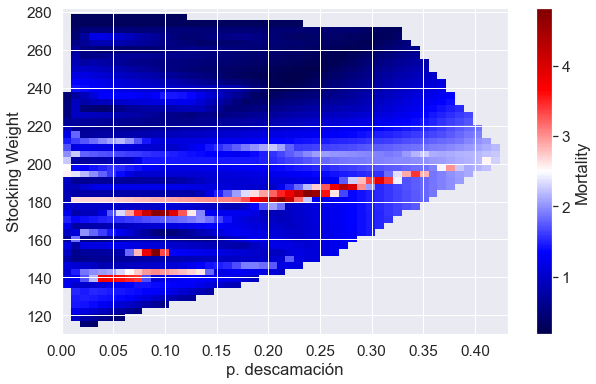

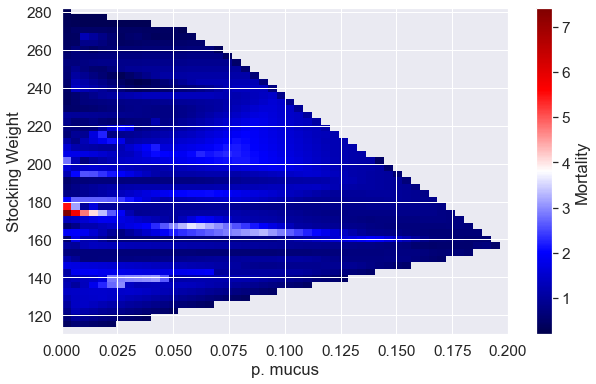

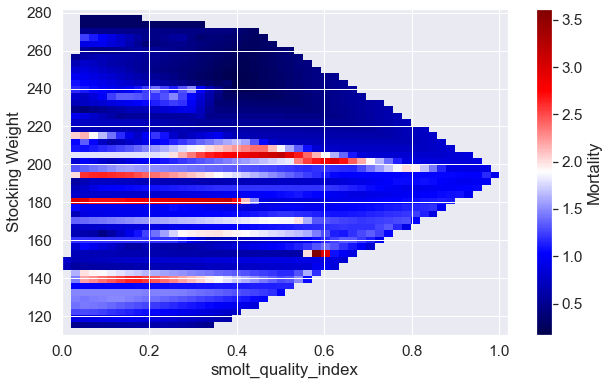

In [61]:
# factor = 'normal'
for factor in ['p. descamación','p. mucus','smolt_quality_index']:
    arr_for_3dchart_ = df_2022_[[factor,'stocking_weight','mortality']].dropna()
    grid_step = 50
    arr_for_3dchart=arr_for_3dchart_.copy()
    # Extract data from DataFrame
    x = arr_for_3dchart[factor]
    y = arr_for_3dchart['stocking_weight']
    # y = arr_for_3dchart['ups_length-whole_period-mean']
    z = arr_for_3dchart['mortality']

    # Define the grid based on x and y values
    x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), grid_step), np.linspace(y.min(), y.max(), grid_step))

    # Calculate the average of mortality in each cell of the grid
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')
    average_mortality = np.mean(z_grid, axis=1)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(z_grid, cmap="seismic", extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')

    # Set labels for the axes
    ax.set_xlabel(f'{factor}')
    ax.set_ylabel('Stocking Weight')

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Mortality')

    # Show the plot
    # plt.show()
#     plt.savefig(vis+path+f'{factor}_vs_stocking_weight_vs_mortality.png',dpi=300)

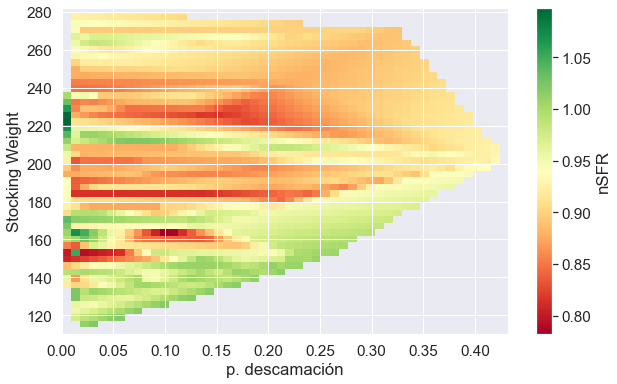

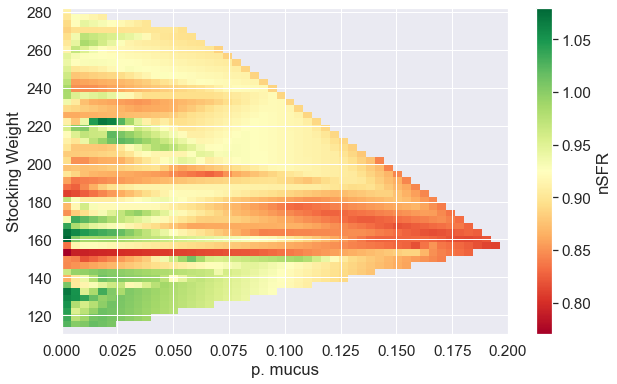

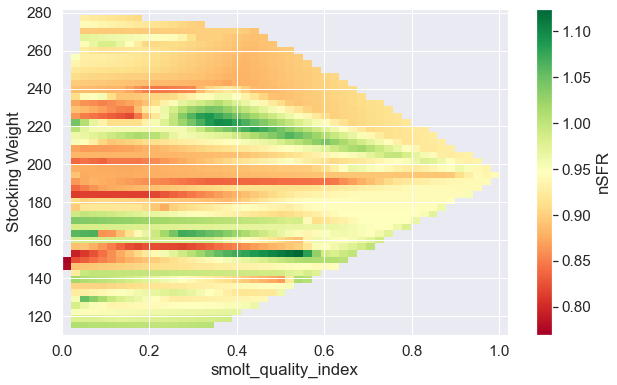

In [62]:
# factor = 'normal'
# for factor in ['normal','grado_1','cataratas','density']:
for factor in ['p. descamación','p. mucus','smolt_quality_index']:
    arr_for_3dchart_ = df_2022_[[factor,'stocking_weight','nsfr']].dropna()
    grid_step = 50
    arr_for_3dchart=arr_for_3dchart_.copy()
    # Extract data from DataFrame
    x = arr_for_3dchart[factor]
    y = arr_for_3dchart['stocking_weight']
    # y = arr_for_3dchart['ups_length-whole_period-mean']
    z = arr_for_3dchart['nsfr']

    # Define the grid based on x and y values
    x_grid, y_grid = np.meshgrid(np.linspace(x.min(), x.max(), grid_step), np.linspace(y.min(), y.max(), grid_step))

    # Calculate the average of mortality in each cell of the grid
    z_grid = griddata((x, y), z, (x_grid, y_grid), method='linear')
    average_mortality = np.mean(z_grid, axis=1)

    # Create the heatmap
    fig, ax = plt.subplots(figsize=(10, 6))
    heatmap = ax.imshow(z_grid, cmap="RdYlGn", extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')

    # Set labels for the axes
    ax.set_xlabel(f'{factor}')
    ax.set_ylabel('Stocking Weight')

    # Add colorbar
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('nSFR')

    # Show the plot
    # plt.show()
#     plt.savefig(f'Visualisation\\sqi\\{factor}_vs_stocking_weight_vs_nSFR.png',dpi=300)

In [63]:
df.event_year.value_counts()

2022    95
2021    77
2023    51
Name: event_year, dtype: int64

<AxesSubplot:>

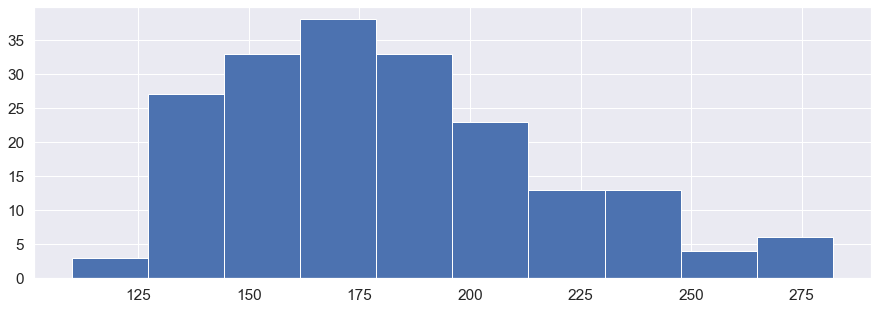

In [65]:
df_2022_.stocking_weight.hist()

In [64]:
len(df_2022_)

193